# Task 1

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# file_path = '/content/drive/.shortcut-targets-by-id/1vkknCL6OjwZzWbtKB-zBXYSXEFQyKkjV/stats m148/dat_train1.csv'
file_path = 'dat_train1.csv'

df = pd.read_csv(file_path)
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

# define a duplicate as same user, same action, same time
duplicate_mask = df.duplicated(subset=['customer_id', 'event_name', 'event_timestamp'], keep='first')
num_duplicates = duplicate_mask.sum()
total_rows_before = len(df)
proportion_duplicates = num_duplicates / total_rows_before

# remove duplicates
df_clean = df[~duplicate_mask].copy()
total_rows_after = len(df_clean)

# fix action counter (journey_steps_until_end)
# sort by customer and time, then group by customer to re-assign the step numbers
df_clean = df_clean.sort_values(by=['customer_id', 'event_timestamp'])
df_clean['journey_steps_until_end'] = df_clean.groupby('customer_id').cumcount() + 1

# 1. Filter for successful orders only
# df_clean is the dataframe after removing duplicates in Task 2
df_orders = df_clean[df_clean['event_name'] == 'order_shipped'].copy()

# Ensure the timestamp is in datetime format
df_orders['event_timestamp'] = pd.to_datetime(df_orders['event_timestamp'])

# Cut off data so it starts in Feb 2021 (data providers mentioned the first little stretch is inaccurate)
df_orders = df_orders[df_orders['event_timestamp'] >= '2021-02-01'].copy()

18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing


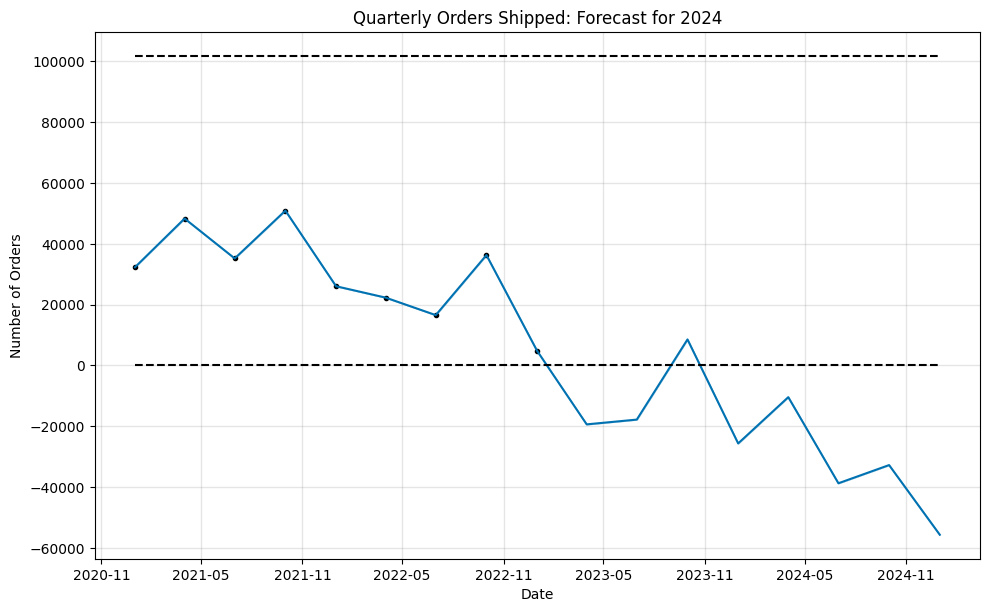

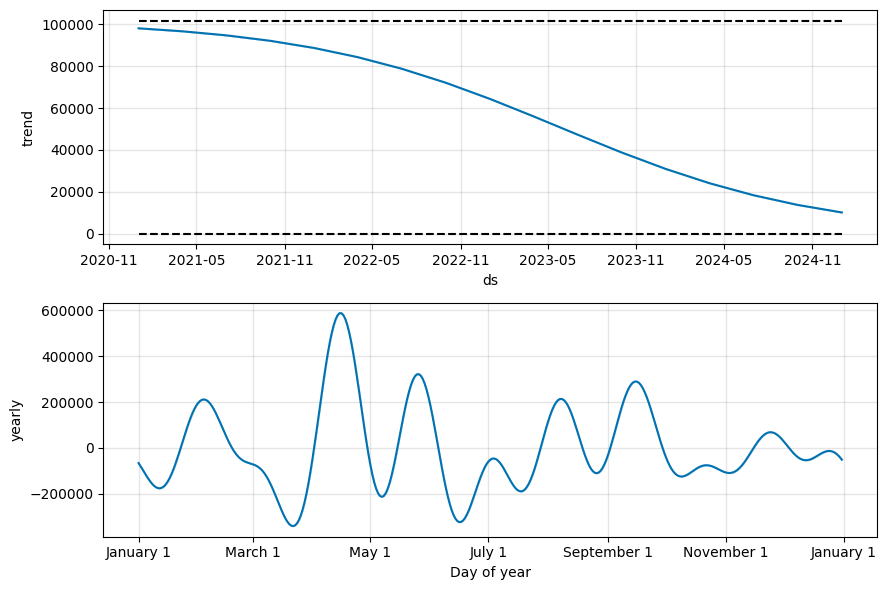

In [ ]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to 0 to prevent negative predictions
quarterly_series['floor'] = 0
# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth to enforce the floor and cap
m = Prophet(growth='logistic')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = 0
future['cap'] = max_orders * 2

forecast = m.predict(future)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing


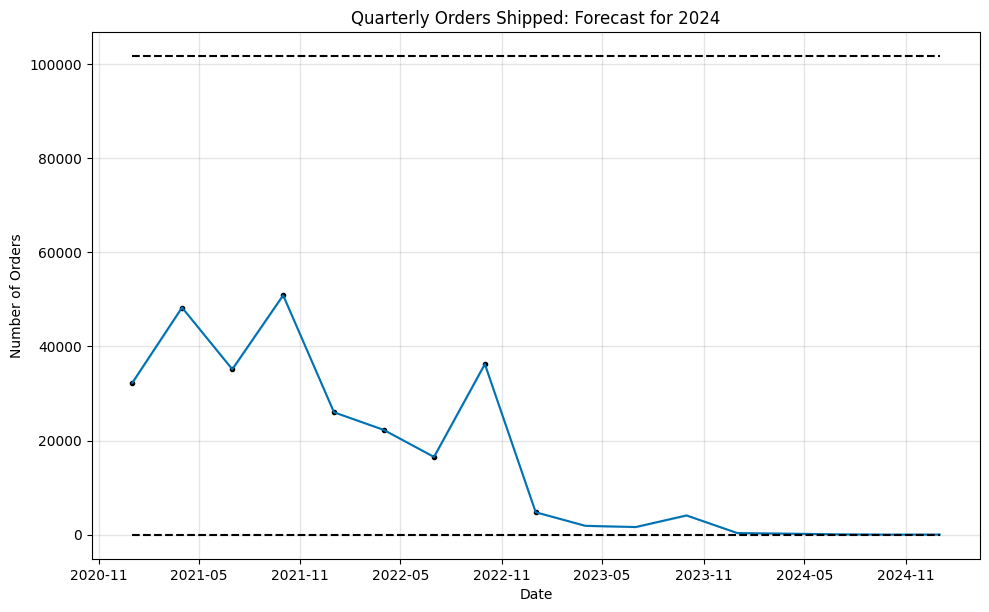

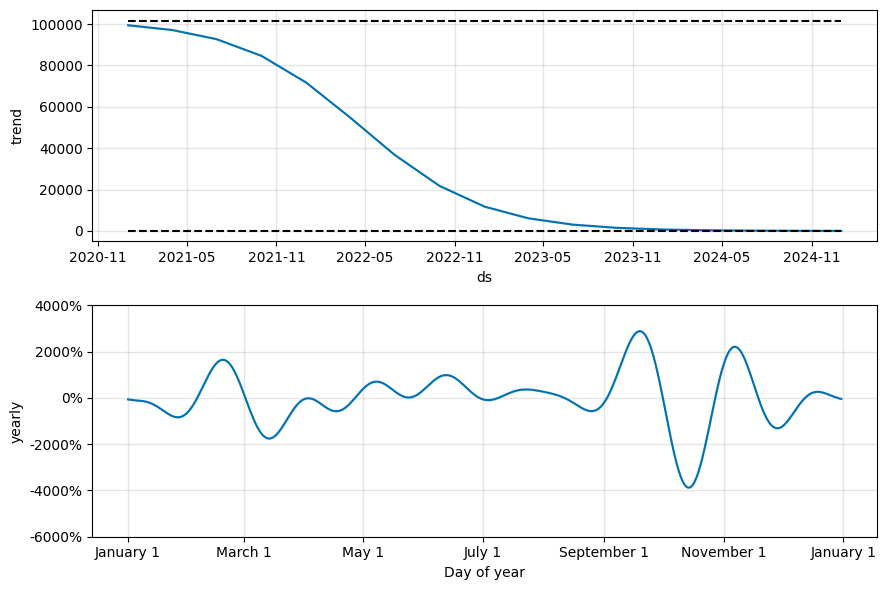

In [ ]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to 0 to prevent negative predictions
quarterly_series['floor'] = 0
# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth AND multiplicative seasonality
m = Prophet(growth='logistic', seasonality_mode='multiplicative')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = 0
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray negative predictions in the main forecast and lower confidence interval to be 0
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

20:03:56 - cmdstanpy - INFO - Chain [1] start processing
20:03:56 - cmdstanpy - INFO - Chain [1] done processing


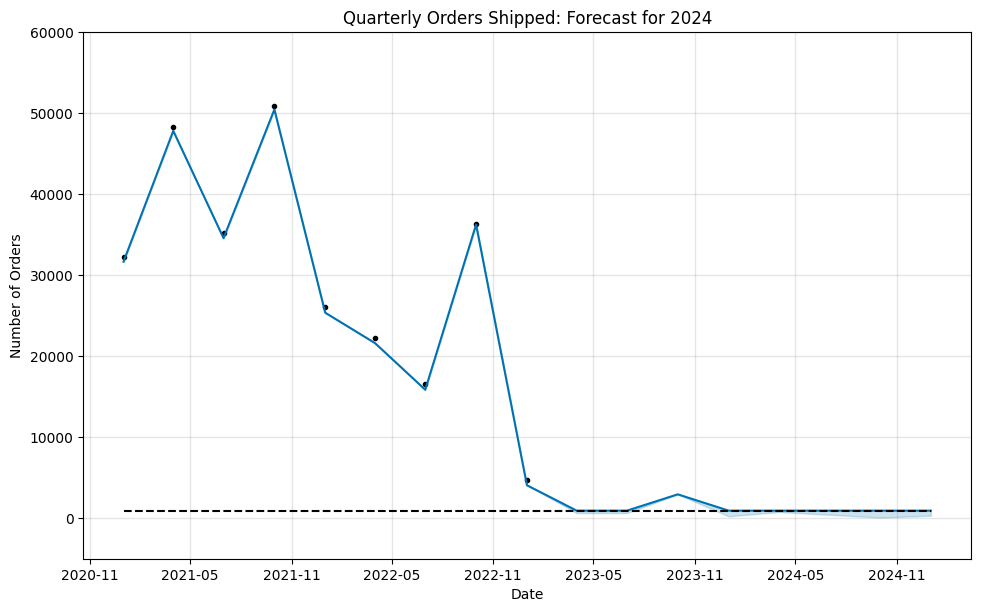

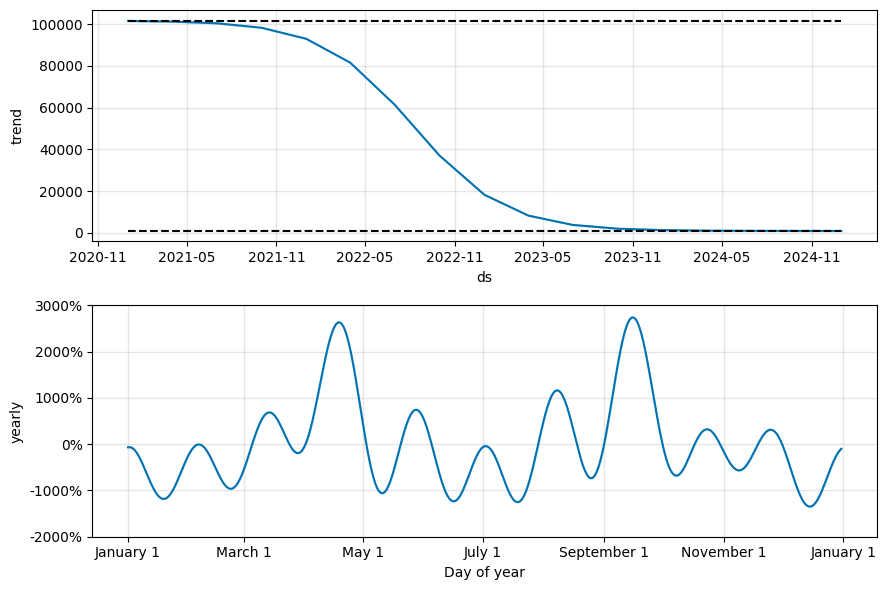

In [ ]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = quarterly_series['y'].mean() * 0.03
quarterly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth to enforce the floor and cap, and multiplicative seasonality
m = Prophet(growth='logistic', seasonality_mode='multiplicative')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.ylim(top = 60000)
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

20:37:12 - cmdstanpy - INFO - Chain [1] start processing
20:37:12 - cmdstanpy - INFO - Chain [1] done processing


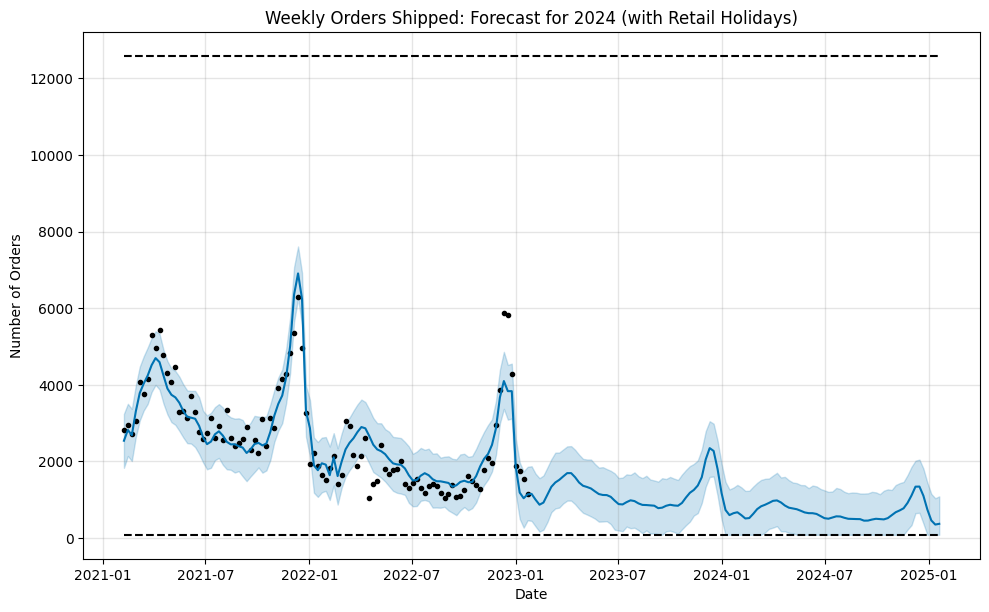

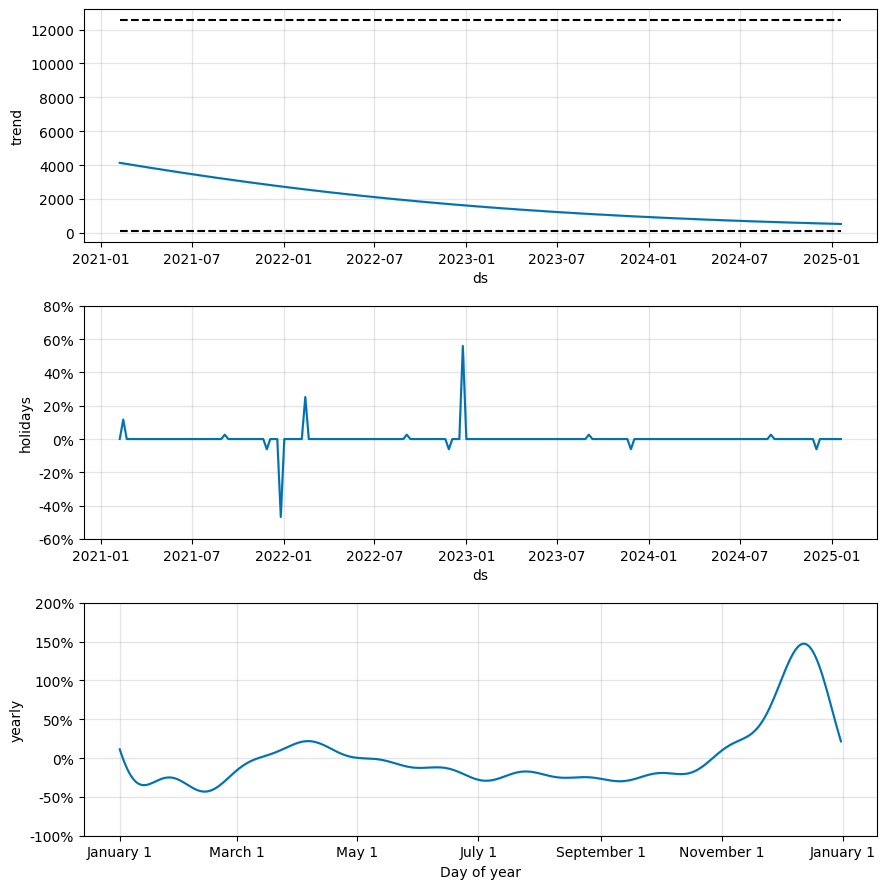

In [ ]:
# 2. Resample to Weekly (W) to get weekly aggregate of orders
# We switch to weekly so holidays are not absorbed by quarterly seasonality
weekly_series = df_orders.resample('W', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
weekly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
weekly_series['ds'] = weekly_series['ds'].dt.tz_localize(None)

# FIX: Drop the final row because it is likely an incomplete week (e.g., ends on a Tuesday)
# This prevents the model from learning an artificial massive drop at the end of the training data
weekly_series = weekly_series.iloc[:-1].copy()

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = weekly_series['y'].mean() * 0.03
weekly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = weekly_series['y'].max()
weekly_series['cap'] = max_orders * 2

# Define the retail holidays for Fingerhut's specific inventory (2021-2024)
holidays_data = {
    'holiday': [
        'Black Friday', 'Black Friday', 'Black Friday', 'Black Friday',
        'Cyber Monday', 'Cyber Monday', 'Cyber Monday', 'Cyber Monday',
        'Christmas', 'Christmas', 'Christmas', 'Christmas',
        'Valentines', 'Valentines', 'Valentines', 'Valentines',
        'Labor Day', 'Labor Day', 'Labor Day', 'Labor Day'
    ],
    'ds': pd.to_datetime([
        '2021-11-26', '2022-11-25', '2023-11-24', '2024-11-29', # Black Friday
        '2021-11-29', '2022-11-28', '2023-11-27', '2024-12-02', # Cyber Monday
        '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25', # Christmas
        '2021-02-14', '2022-02-14', '2023-02-14', '2024-02-14', # Valentines (Jewelry)
        '2021-09-06', '2022-09-05', '2023-09-04', '2024-09-02'  # Labor Day (Appliances)
    ]),
    'lower_window': -3, # Extends the holiday effect 3 days before
    'upper_window': 3   # Extends the holiday effect 3 days after to match the weekly grouping
}
retail_holidays = pd.DataFrame(holidays_data)

# 3. Fit the model using logistic growth, multiplicative seasonality, and retail holidays
# We forcefully set yearly_seasonality=True because our dataset is just barely under 730 days
m = Prophet(
    growth='logistic', 
    seasonality_mode='multiplicative', 
    holidays=retail_holidays,
    yearly_seasonality=True
)
m.fit(weekly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 104 weeks (2 years) into the future
future = m.make_future_dataframe(periods=104, freq='W')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Weekly Orders Shipped: Forecast for 2024 (with Retail Holidays)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

14:08:24 - cmdstanpy - INFO - Chain [1] start processing
14:08:24 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


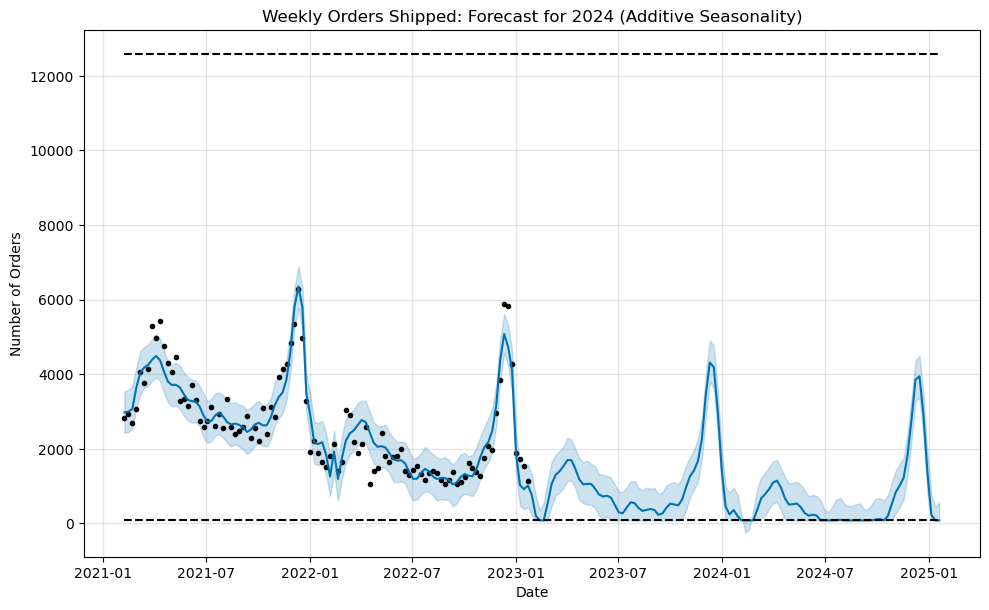

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

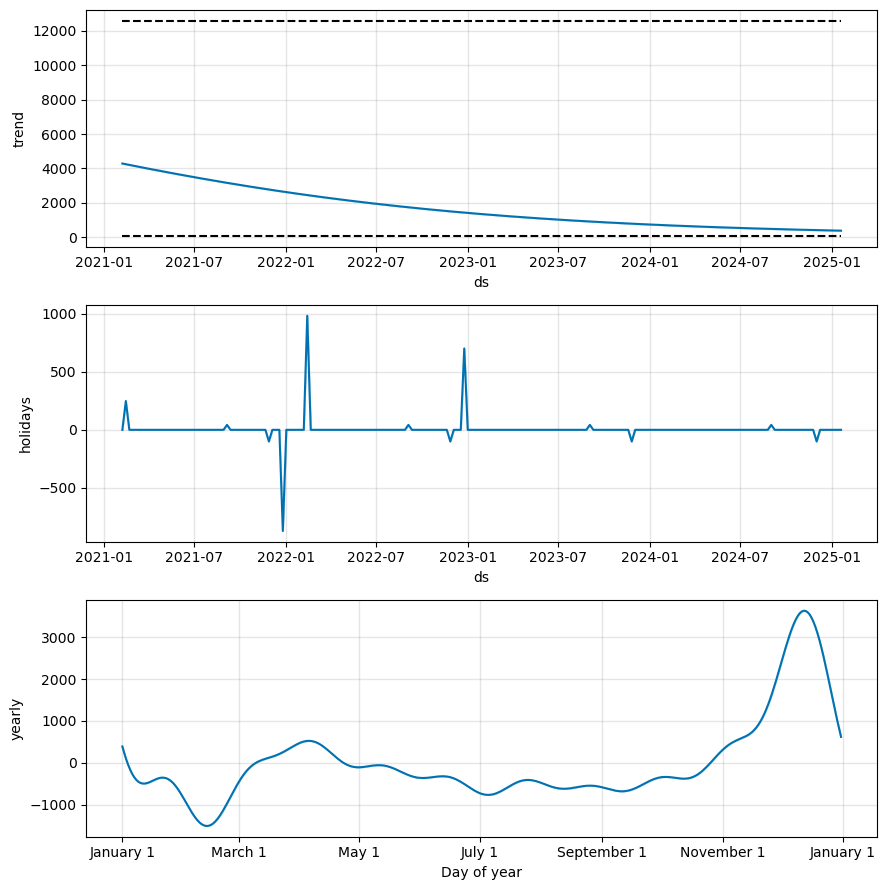

In [ ]:
# 2. Resample to Weekly (W) to get weekly aggregate of orders
# We switch to weekly so holidays are not absorbed by quarterly seasonality
weekly_series = df_orders.resample('W', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
weekly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
weekly_series['ds'] = weekly_series['ds'].dt.tz_localize(None)

# FIX: Drop the final row because it is likely an incomplete week (e.g., ends on a Tuesday)
# This prevents the model from learning an artificial massive drop at the end of the training data
weekly_series = weekly_series.iloc[:-1].copy()

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = weekly_series['y'].mean() * 0.03
weekly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = weekly_series['y'].max()
weekly_series['cap'] = max_orders * 2

# Define the retail holidays for Fingerhut's specific inventory (2021-2024)
holidays_data = {
    'holiday': [
        'Black Friday', 'Black Friday', 'Black Friday', 'Black Friday',
        'Cyber Monday', 'Cyber Monday', 'Cyber Monday', 'Cyber Monday',
        'Christmas', 'Christmas', 'Christmas', 'Christmas',
        'Valentines', 'Valentines', 'Valentines', 'Valentines',
        'Labor Day', 'Labor Day', 'Labor Day', 'Labor Day'
    ],
    'ds': pd.to_datetime([
        '2021-11-26', '2022-11-25', '2023-11-24', '2024-11-29', # Black Friday
        '2021-11-29', '2022-11-28', '2023-11-27', '2024-12-02', # Cyber Monday
        '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25', # Christmas
        '2021-02-14', '2022-02-14', '2023-02-14', '2024-02-14', # Valentines (Jewelry)
        '2021-09-06', '2022-09-05', '2023-09-04', '2024-09-02'  # Labor Day (Appliances)
    ]),
    'lower_window': -3, # Extends the holiday effect 3 days before
    'upper_window': 3   # Extends the holiday effect 3 days after to match the weekly grouping
}
retail_holidays = pd.DataFrame(holidays_data)

# 3. Fit the model using logistic growth, ADDITIVE seasonality, and retail holidays
# We forcefully set yearly_seasonality=True because our dataset is just barely under 730 days
m = Prophet(
    growth='logistic', 
    seasonality_mode='additive', 
    holidays=retail_holidays,
    yearly_seasonality=True
)
m.fit(weekly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 104 weeks (2 years) into the future
future = m.make_future_dataframe(periods=104, freq='W')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Weekly Orders Shipped: Forecast for 2024 (Additive Seasonality)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

14:22:11 - cmdstanpy - INFO - Chain [1] start processing
14:22:11 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  447.491747   79.220680 1298.494373
2024-01-14  237.541143   79.220680 1117.247418
2024-01-21  357.586362   79.220680 1285.720762
2024-01-28  195.911495   79.220680 1055.767131
2024-02-04   79.220680   79.220680  515.062118
2024-02-11   79.220680   79.220680  104.444086
2024-02-18   79.220680   79.220680  138.858303
2024-02-25   79.220680   79.220680  668.110727
2024-03-03  371.198920   79.220680 1228.538547
2024-03-10  673.385395   79.220680 1468.243778
2024-03-17  785.638974   79.220680 1674.546586
2024-03-24  918.561653   99.044690 1760.034813
2024-03-31 1096.223703  240.015409 1943.971147
2024-04-07 1142.451521  312.784940 2043.863097
2024-04-14  953.757548   94.225072 1842.362775
2024-04-21  667.420103   79.220680 1507.250280
2024-04-28  505.113105   79.220680 1414.952789
2024-05-05  511.527868   79.220680 1306.585294
2024-05-12  530.407683   79.220680 1374.968987
2024-05-19  431.376447   79.220680 1290.036282
2024-05-26  2

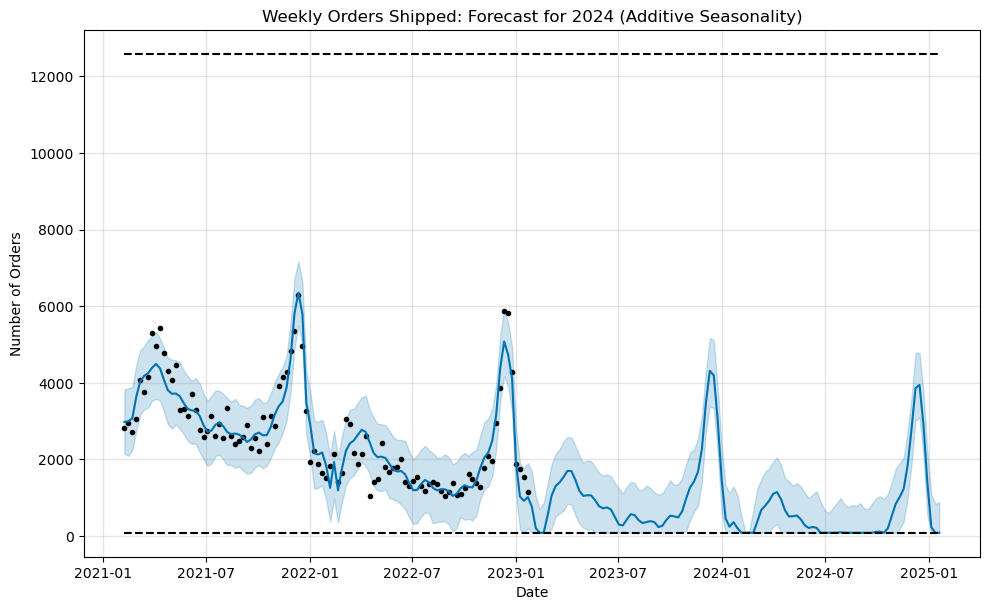

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

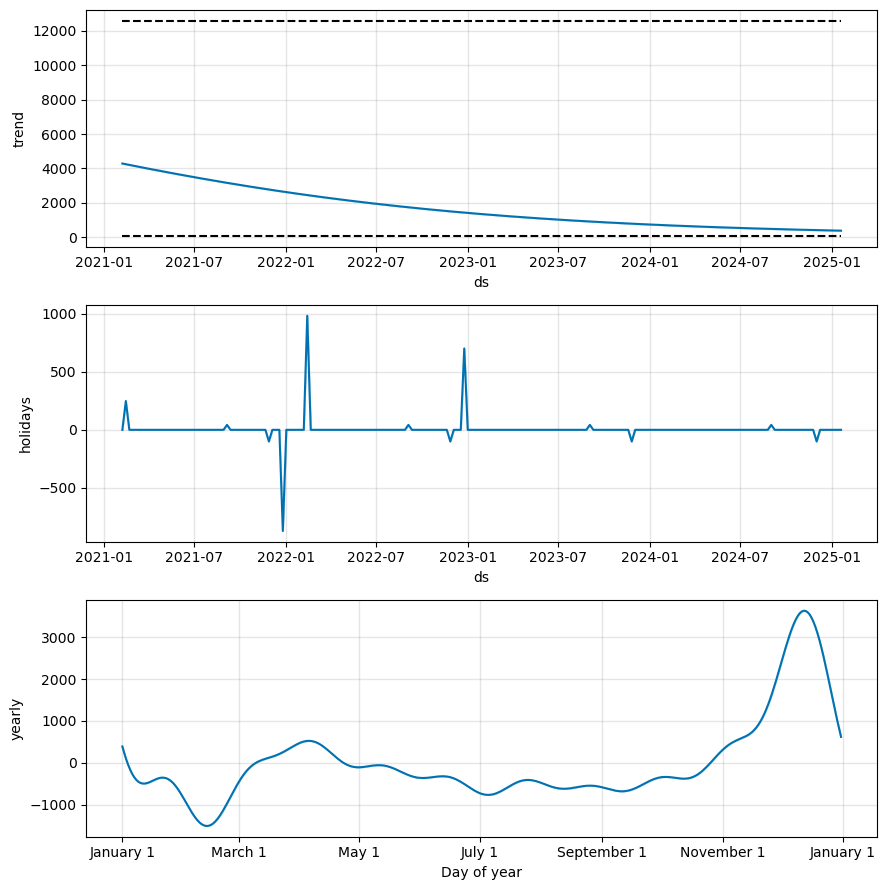

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... your preprocessing code up to retail_holidays ...

# 3. Fit the model with 95% intervals
m = Prophet(
    growth='logistic',
    seasonality_mode='additive',
    holidays=retail_holidays,
    yearly_seasonality=True,
    interval_width=0.95  # <--- key change for 95% CI
)
m.fit(weekly_series)

# 4. Forecast forward
future = m.make_future_dataframe(periods=104, freq='W')
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Keep predictions and intervals respecting the floor (and optionally cap)
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=baseline_orders)  # recommended

# 4b. Report predictions for 2024 only (weekly)
pred_2024 = forecast.loc[
    (forecast['ds'] >= '2024-01-01') & (forecast['ds'] < '2025-01-01'),
    ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
].copy()

pred_2024.rename(columns={
    'yhat': 'pred_mean',
    'yhat_lower': 'ci95_lower',
    'yhat_upper': 'ci95_upper'
}, inplace=True)

# Print the per-week outputs (mean + 95% CI)
print(pred_2024.to_string(index=False))

# Optional: a compact summary for the whole year (often nice to include)
summary_2024 = pd.Series({
    "avg_weekly_pred_mean_2024": pred_2024['pred_mean'].mean(),
    "avg_weekly_ci95_lower_2024": pred_2024['ci95_lower'].mean(),
    "avg_weekly_ci95_upper_2024": pred_2024['ci95_upper'].mean(),
    "total_predicted_orders_2024": pred_2024['pred_mean'].sum()
})
print("\n2024 prediction summary:")
print(summary_2024)

# Optional: save for grading / submission
pred_2024.to_csv("weekly_predictions_2024_with_ci95.csv", index=False)

# 5. Plot forecast (unchanged)
fig1 = m.plot(forecast)
plt.title('Weekly Orders Shipped: Forecast for 2024 (Additive Seasonality)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

fig2 = m.plot_components(forecast)
plt.show()


In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(
    m,
    initial='365 days',     # train window
    period='90 days',       # spacing between cutoffs
    horizon='180 days'      # forecast horizon
)

df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'mse', 'rmse', 'mae']])


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.76it/s]14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:15 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

    horizon           mse         rmse          mae
0   18 days  1.221358e+05   349.479334   292.775841
1   19 days  1.020808e+05   319.500812   266.744013
2   25 days  9.877219e+04   314.280438   248.682939
3   26 days  4.616982e+04   214.871643   167.250532
4   32 days  4.974633e+04   223.038848   172.402601
5   33 days  4.969529e+04   222.924402   169.544352
6   39 days  7.207017e+04   268.458873   198.116345
7   40 days  7.409464e+04   272.203307   210.990351
8   46 days  1.572939e+05   396.602951   318.297520
9   47 days  1.783346e+05   422.296802   343.211889
10  53 days  1.825024e+05   427.202993   371.729006
11  54 days  1.421163e+05   376.983127   301.423564
12  60 days  1.542343e+05   392.726778   333.249941
13  61 days  6.833342e+04   261.406626   207.533837
14  67 days  9.308172e+04   305.092973   230.378771
15  68 days  9.242662e+04   304.017474   228.013011
16  74 days  1.860223e+05   431.302999   344.343798
17  75 days  2.308668e+05   480.486023   399.367447
18  81 days 

In [ ]:
(raw_lower_min, raw_lower_med) = (forecast['yhat_lower'].min(), forecast['yhat_lower'].median())
print("baseline_orders:", baseline_orders)
print("min yhat_lower after clip:", forecast['yhat_lower'].min())
print("fraction clipped:", (forecast['yhat_lower'] == baseline_orders).mean())


baseline_orders: 79.22067961165048
min yhat_lower after clip: 79.22067961165048
fraction clipped: 0.34782608695652173


In [ ]:
forecast2 = m.predict(future)

pred_2024_raw = forecast2.loc[
    (forecast2['ds'] >= '2024-01-01') & (forecast2['ds'] < '2025-01-01'),
    ['ds','yhat','yhat_lower','yhat_upper']
]

print("baseline_orders:", baseline_orders)
print("fraction where raw lower < floor:", (pred_2024_raw['yhat_lower'] < baseline_orders).mean())
print(pred_2024_raw.head(10))


baseline_orders: 79.22067961165048
fraction where raw lower < floor: 0.7884615384615384
            ds        yhat   yhat_lower   yhat_upper
152 2024-01-07  447.491747  -365.427665  1304.328949
153 2024-01-14  237.541143  -679.770738  1056.099497
154 2024-01-21  357.586362  -509.678184  1241.224249
155 2024-01-28  195.911495  -627.752607  1066.787056
156 2024-02-04 -334.152915 -1233.930579   567.684297
157 2024-02-11 -779.034948 -1706.152624   150.713989
158 2024-02-18 -711.066903 -1527.300203   109.560081
159 2024-02-25 -188.676349 -1110.643770   603.107052
160 2024-03-03  371.198920  -475.861970  1234.767019
161 2024-03-10  673.385395  -189.347806  1477.490311


# Task 3

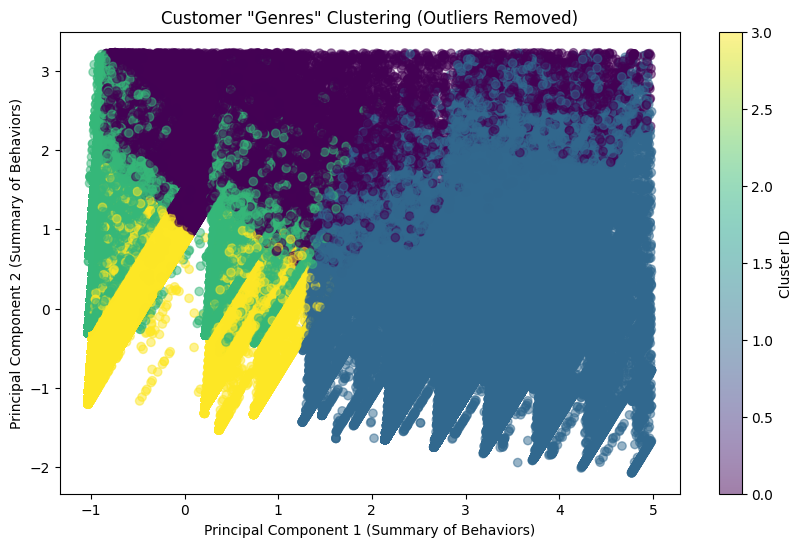

Average Stage Interactions per Cluster:
stage    Apply for Credit  Credit Account  Discover  Downpayment  \
cluster                                                            
0                   28.13            0.37      0.95         0.32   
1                    5.54            1.02      0.60         2.29   
2                    4.78            0.05      1.03         0.01   
3                    5.60            0.05      0.00         0.01   

stage    First Purchase  Order Shipped  
cluster                                 
0                113.83           0.11  
1                 38.27           0.97  
2                 13.68           0.00  
3                 14.48           0.00  


In [ ]:
import pandas as pd
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Load the provided key mapping into a DataFrame
key_csv_data = """event_name,journey_id,event_definition_id,milestone_number,stage
application_phone_approved,1,15,1,Apply for Credit
application_phone_declined,1,16,,Apply for Credit
application_phone_pending,1,17,,Apply for Credit
application_web_approved,1,12,1,Apply for Credit
application_web_declined,1,13,,Apply for Credit
application_web_pending,1,14,,Apply for Credit
application_web_submit,1,3,,Apply for Credit
application_web_view,1,19,,Apply for Credit
account_activitation,1,29,3,Credit Account
account_fraud_review,1,37,,Credit Account
campaign_click,1,2,,Discover
customer_requested_catalog_digital,1,9,,Discover
fingerhut_university,1,10,,Discover
pre_application_3rd_party_affiliates,1,22,,Discover
site_registration,1,23,,Discover
account_downpaymentcleared,1,27,5,Downpayment
account_downpaymentreceived,1,26,,Downpayment
place_downpayment,1,8,4,Downpayment
place_downpayment_phone,1,25,4,Downpayment
add_to_cart,1,11,,First Purchase
begin_checkout,1,6,,First Purchase
browse_products,1,4,,First Purchase
place_order_phone,1,18,2,First Purchase
place_order_web,1,7,2,First Purchase
view_cart,1,5,,First Purchase
order_shipped,1,28,6,Order Shipped
catalog_email_experian,1,20,,Prospecting
catalog_mail,1,21,,Prospecting"""

df_key = pd.read_csv(io.StringIO(key_csv_data))

# 2. Merge the stages onto your clean tracking data
# df_clean is the dataframe after removing duplicates in Task 2
df_merged = df_clean.merge(df_key[['event_name', 'stage']], on='event_name', how='left')

# 3. Create a feature matrix: count of interactions per stage for each customer
customer_profiles = pd.crosstab(df_merged['customer_id'], df_merged['stage'])

# 4. Scale the features so stages with high volume do not dominate the distance metrics
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profiles)

# 5. Apply K-Means Clustering (starting with 4 clusters as a guess)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_profiles['cluster'] = kmeans.fit_predict(scaled_features)

import numpy as np
from scipy import stats

# 6. Reduce dimensions to 2D using PCA for visualization purposes
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# 7. Identify outliers using Z-scores on the PCA features
# Calculate the Z-score for each principal component
z_scores = np.abs(stats.zscore(pca_features))

# Define a threshold (e.g., 3 standard deviations from the mean)
threshold = 3

# Create a boolean mask to keep only the rows where both PCA components are within the threshold
# This filters out extreme outliers that stretch the plot
mask = (z_scores[:, 0] < threshold) & (z_scores[:, 1] < threshold)

# Apply the mask to our features and cluster labels
clean_pca_features = pca_features[mask]
clean_clusters = customer_profiles['cluster'].values[mask]

# 8. Plot the cleaned clusters
plt.figure(figsize=(10, 6))
plt.scatter(clean_pca_features[:, 0], clean_pca_features[:, 1], c=clean_clusters, cmap='viridis', alpha=0.5)
plt.title('Customer "Genres" Clustering (Outliers Removed)')
plt.xlabel('Principal Component 1 (Summary of Behaviors)')
plt.ylabel('Principal Component 2 (Summary of Behaviors)')
plt.colorbar(label='Cluster ID')
plt.show()

# 9. Output the average stage interactions per cluster to interpret the "genres"
cluster_summary = customer_profiles.groupby('cluster').mean()
print("Average Stage Interactions per Cluster:")
print(cluster_summary.round(2))

### Weekly model with additional CI info

14:25:59 - cmdstanpy - INFO - Chain [1] start processing
14:25:59 - cmdstanpy - INFO - Chain [1] done processing
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  773.590878  526.444525 1133.823006
2024-01-14  680.509864  459.732317  977.473866
2024-01-21  651.915284  446.665923  946.659596
2024-01-28  604.543720  415.410878  873.308357
2024-02-04  529.984200  363.352318  752.805884
2024-02-11  478.669481  335.611273  705.901104
2024-02-18  486.893345  335.731025  698.428582
2024-02-25  553.861552  385.986579  823.429634
2024-03-03  644.290318  441.073039  923.839813
2024-03-10  709.119844  491.463461 1042.549084
2024-03-17  733.703219  493.913458 1053.317143
2024-03-24  738.863667  508.165351 1088.806363
2024-03-31  734.450539  507.304503 1092.252669
2024-04-07  708.604969  492.462931 1035.333346
2024-04-14  660.840459  437.678852  956.833483
2024-04-21  617.219169  435.580867  897.554064
2024-04-28  602.382517  414.215435  849.481498
2024-05-05  613.796320  434.093919  876.396038
2024-05-12  624.639686  437.578392  901.761381
2024-05-19  612.643797  418.837803  897.890698
2024-05-26  5

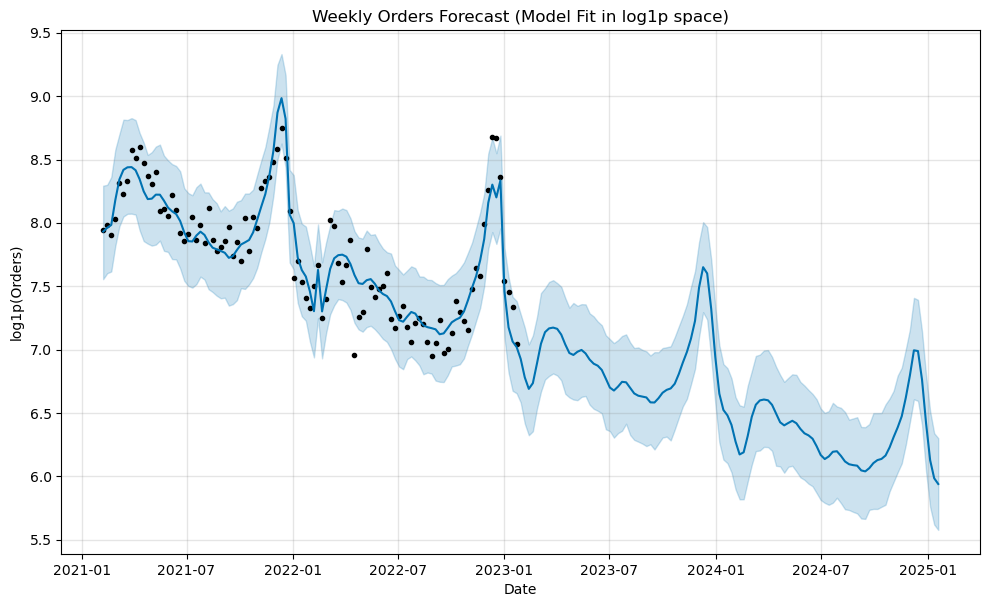

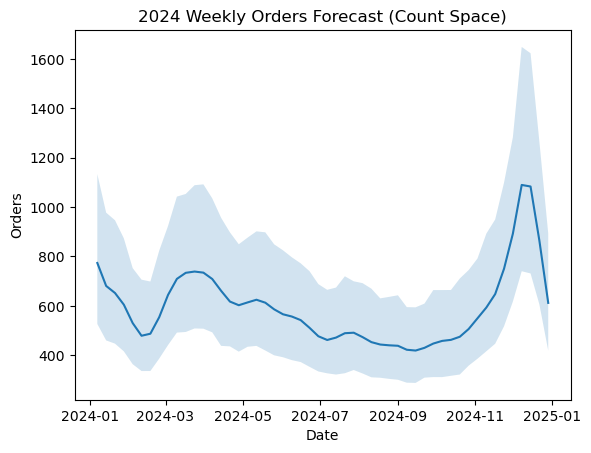

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

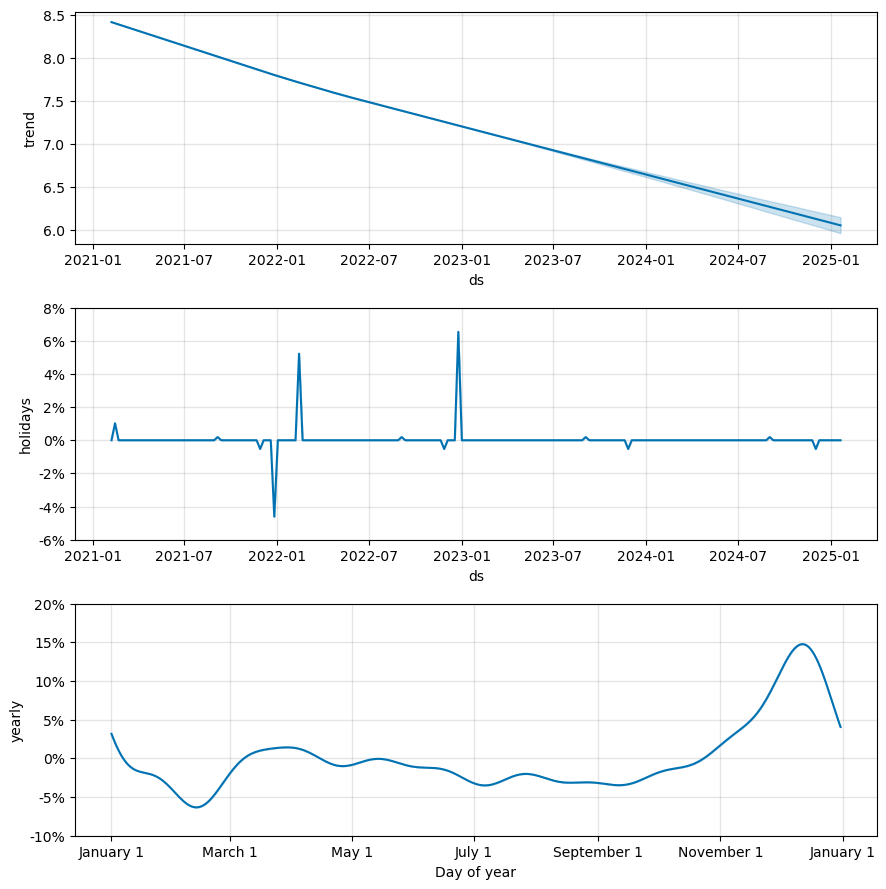

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# weekly_series must already exist with columns: ds, y
# retail_holidays must already exist

weekly = weekly_series.copy()

# 1) Transform target to stabilize variance and avoid negative forecasts
weekly['y_log'] = np.log1p(weekly['y'])

# Prophet expects target column to be named y
weekly_for_prophet = weekly[['ds', 'y_log']].rename(columns={'y_log': 'y'}).copy()

# 2) Fit model
m = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    holidays=retail_holidays,
    changepoint_prior_scale=0.01,   # smoother trend
    seasonality_prior_scale=5,
    holidays_prior_scale=5,
    interval_width=0.95
)
m.fit(weekly_for_prophet)

# 3) Forecast forward
future = m.make_future_dataframe(periods=104, freq='W')
forecast_log = m.predict(future)

# 4) Invert transform back to counts
forecast = forecast_log.copy()
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = np.expm1(forecast[col])

# counts should not be negative after inverse, but clip just in case
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = forecast[col].clip(lower=0)

# 5) Report 2024 predictions (mean + 95% CI)
pred_2024 = forecast.loc[
    (forecast['ds'] >= '2024-01-01') & (forecast['ds'] < '2025-01-01'),
    ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
].copy()

pred_2024.rename(columns={
    'yhat': 'pred_mean',
    'yhat_lower': 'ci95_lower',
    'yhat_upper': 'ci95_upper'
}, inplace=True)

print(pred_2024.to_string(index=False))

summary_2024 = pd.Series({
    "avg_weekly_pred_mean_2024": pred_2024['pred_mean'].mean(),
    "avg_weekly_ci95_lower_2024": pred_2024['ci95_lower'].mean(),
    "avg_weekly_ci95_upper_2024": pred_2024['ci95_upper'].mean(),
    "total_predicted_orders_2024": pred_2024['pred_mean'].sum()
})
print("\n2024 prediction summary:")
print(summary_2024)

pred_2024.to_csv("weekly_predictions_2024_with_ci95_log_model.csv", index=False)

# 6) Plots
fig1 = m.plot(forecast_log)  # plot in log space (Prophet internal)
plt.title('Weekly Orders Forecast (Model Fit in log1p space)')
plt.xlabel('Date')
plt.ylabel('log1p(Orders)')
plt.show()

# Optional: plot in original count space
plt.figure()
plt.plot(pred_2024['ds'], pred_2024['pred_mean'])
plt.fill_between(pred_2024['ds'], pred_2024['ci95_lower'], pred_2024['ci95_upper'], alpha=0.2)
plt.title('2024 Weekly Orders Forecast (Count Space)')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.show()

fig2 = m.plot_components(forecast_log)
plt.show()


### Cross Validation Method

In [ ]:
from itertools import product
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd

# Build training data for Prophet (log model)
train_df = weekly_series[['ds', 'y']].copy()
train_df['y'] = np.log1p(train_df['y'])

# A small hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.02, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
    'holidays_prior_scale': [1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

results = []

for params in all_params:
    # m_cv = Prophet(
    #     growth='linear',
    #     yearly_seasonality=True,
    #     holidays=retail_holidays,
    #     interval_width=0.95,
    #     changepoint_prior_scale=params['changepoint_prior_scale'],
    #     seasonality_prior_scale=params['seasonality_prior_scale'],
    #     holidays_prior_scale=params['holidays_prior_scale'],
    #     seasonality_mode=params['seasonality_mode']
    # )
    m_cv = Prophet(
        growth='linear',
        seasonality_mode='multiplicative',
        yearly_seasonality=True,
        holidays=retail_holidays,
        changepoint_prior_scale=0.02,   # smoother trend
        seasonality_prior_scale=5,
        holidays_prior_scale=5,
        interval_width=0.95
    )

    m_cv.add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=5
)
    m_cv.fit(train_df)

    df_cv = cross_validation(
        m_cv,
        initial='365 days',
        period='90 days',
        horizon='180 days'
    )

    df_p = performance_metrics(df_cv)

    # This MSE is in log space since the model was fit in log space
    mean_mse = df_p['mse'].mean()

    results.append({
        **params,
        'cv_mse_log_space': mean_mse,
        'cv_rmse_log_space': df_p['rmse'].mean()
    })

results_df = pd.DataFrame(results).sort_values('cv_mse_log_space')
print(results_df.head(10).to_string(index=False))

best_params = results_df.iloc[0].to_dict()
print("\nBest params:")
print(best_params)


14:28:33 - cmdstanpy - INFO - Chain [1] start processing
14:28:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  1.90it/s]14:28:34 - cmdstanpy - INFO - Chain [1] start processing
14:28:34 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  2.03it/s]
14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  1.84it/s]14:28:35 - cmdsta

 changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale seasonality_mode  cv_mse_log_space  cv_rmse_log_space
                    0.01                      1.0                   1.0         additive          0.086856           0.219883
                    0.05                      1.0                  10.0         additive          0.086856           0.219883
                    0.05                      1.0                  10.0   multiplicative          0.086856           0.219883
                    0.05                      5.0                   1.0         additive          0.086856           0.219883
                    0.05                      5.0                   1.0   multiplicative          0.086856           0.219883
                    0.05                      5.0                  10.0         additive          0.086856           0.219883
                    0.05                      5.0                  10.0   multiplicative          0.086856           0

In [ ]:
df_cv_counts = df_cv.copy()
df_cv_counts['y_count'] = np.expm1(df_cv_counts['y'])
df_cv_counts['yhat_count'] = np.expm1(df_cv_counts['yhat'])

mse_count_space = np.mean((df_cv_counts['y_count'] - df_cv_counts['yhat_count'])**2)
print("CV MSE in count space:", mse_count_space)


CV MSE in count space: 691908.3194075581


### Feature selection

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from itertools import product

train_df = weekly_series[['ds','y']].copy()
train_df['y'] = np.log1p(train_df['y'])

grid = {
    "seasonality_mode": ["additive", "multiplicative"],
    "use_quarterly": [False, True],
    "changepoint_prior_scale": [0.01, 0.02, 0.05],
    "use_holidays": [True, False],  # set to [True] if you want fewer runs
}

rows = []

for seasonality_mode, use_quarterly, cps, use_holidays in product(
    grid["seasonality_mode"],
    grid["use_quarterly"],
    grid["changepoint_prior_scale"],
    grid["use_holidays"]
):
    m = Prophet(
        growth="linear",
        yearly_seasonality=True,
        seasonality_mode=seasonality_mode,
        holidays=retail_holidays if use_holidays else None,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=5,
        holidays_prior_scale=5,
        interval_width=0.95
    )

    if use_quarterly:
        m.add_seasonality(name="quarterly", period=365.25/4, fourier_order=5)

    m.fit(train_df)

    df_cv = cross_validation(m, initial="365 days", period="90 days", horizon="180 days")
    df_cv_tmp = df_cv.copy()
    df_cv_tmp["y_count"] = np.expm1(df_cv_tmp["y"])
    df_cv_tmp["yhat_count"] = np.expm1(df_cv_tmp["yhat"])
    mse_count = np.mean((df_cv_tmp["y_count"] - df_cv_tmp["yhat_count"])**2)
    rmse_count = np.sqrt(mse_count)

    df_p = performance_metrics(df_cv)

    rows.append({
        "seasonality_mode": seasonality_mode,
        "use_quarterly": use_quarterly,
        "changepoint_prior_scale": cps,
        "use_holidays": use_holidays,
        "mse_log": df_p["mse"].mean(),
        "rmse_log": df_p["rmse"].mean()
    })

results = pd.DataFrame(rows).sort_values("mse_log")
print(results.head(10).to_string(index=False))


14:37:50 - cmdstanpy - INFO - Chain [1] start processing
14:37:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]14:37:50 - cmdstanpy - INFO - Chain [1] start processing
14:37:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.49it/s]14:37:51 - cmdstanpy - INFO - Chain [1] start processing
14:37:51 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  3.39it/s]
14:37:51 - cmdstanpy - INFO - Chain [1] start processing
14:37:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]14:37:51 - cmdstanpy - INFO - Chain [1] start processing
14:37:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.86it/s]14:37:51 - cmdsta

seasonality_mode  use_quarterly  changepoint_prior_scale  use_holidays  mse_log  rmse_log
        additive           True                     0.01         False 0.069624  0.200739
        additive           True                     0.02         False 0.069669  0.200765
        additive          False                     0.02         False 0.076585  0.224178
        additive          False                     0.01         False 0.077386  0.225050
  multiplicative           True                     0.01         False 0.078167  0.210797
  multiplicative           True                     0.02         False 0.078320  0.210818
        additive           True                     0.02          True 0.078916  0.210684
        additive           True                     0.01          True 0.079160  0.210404
        additive          False                     0.01          True 0.081921  0.233040
        additive          False                     0.02          True 0.082229  0.233389


15:15:20 - cmdstanpy - INFO - Chain [1] start processing
15:15:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]15:15:20 - cmdstanpy - INFO - Chain [1] start processing
15:15:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  4.74it/s]15:15:21 - cmdstanpy - INFO - Chain [1] start processing
15:15:21 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  4.92it/s]
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73:

Cross-Validated MSE (count space): 579543.880979092
Cross-Validated RMSE (count space): 761.2777948811406
        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  877.051878  616.120290 1232.912156
2024-01-14  720.014766  507.775832 1034.907887
2024-01-21  590.805870  414.695733  852.511660
2024-01-28  559.217679  404.247529  788.226749
2024-02-04  571.061524  402.339100  828.305223
2024-02-11  561.385459  395.931120  810.443063
2024-02-18  497.325076  345.912646  708.904449
2024-02-25  516.258483  364.671997  732.110577
2024-03-03  685.546271  479.578913  960.480880
2024-03-10  810.115511  581.737271 1158.669753
2024-03-17  795.168514  549.090906 1122.375136
2024-03-24  738.912292  526.876703 1033.648878
2024-03-31  745.138221  526.869410 1054.680834
2024-04-07  818.812325  594.392747 1176.942029
2024-04-14  732.977805  516.092399 1018.528281
2024-04-21  584.810480  405.601542  811.635868
2024-04-28  570.826981  407.564011  818.393318
2024-05-05  663.311791  474.008125  937.322576
2

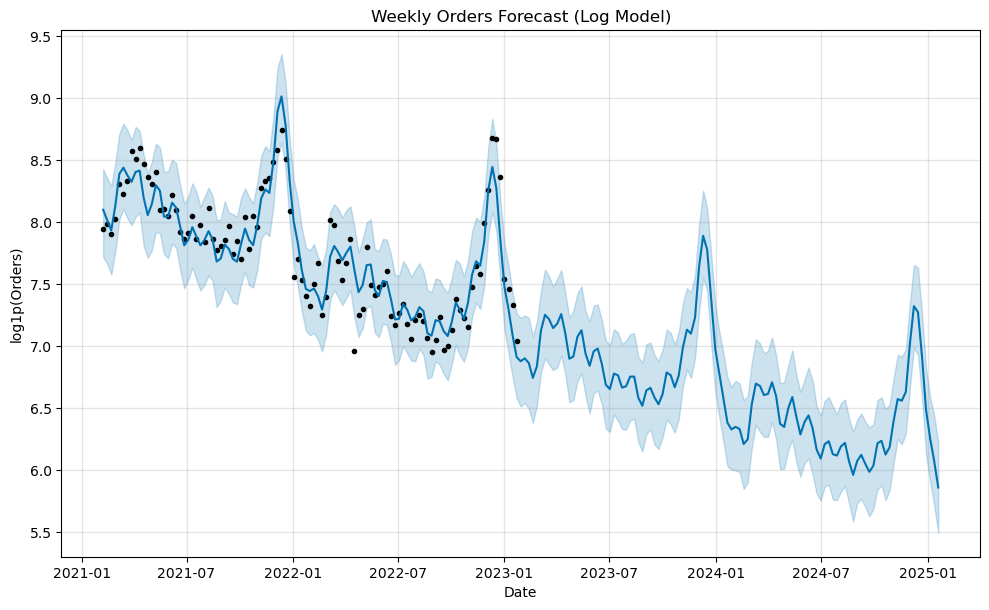

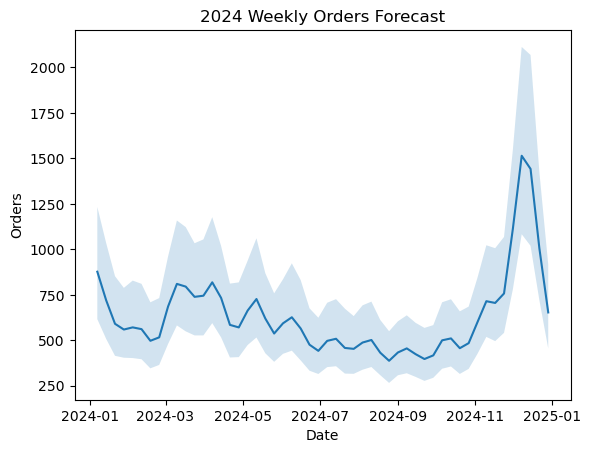

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

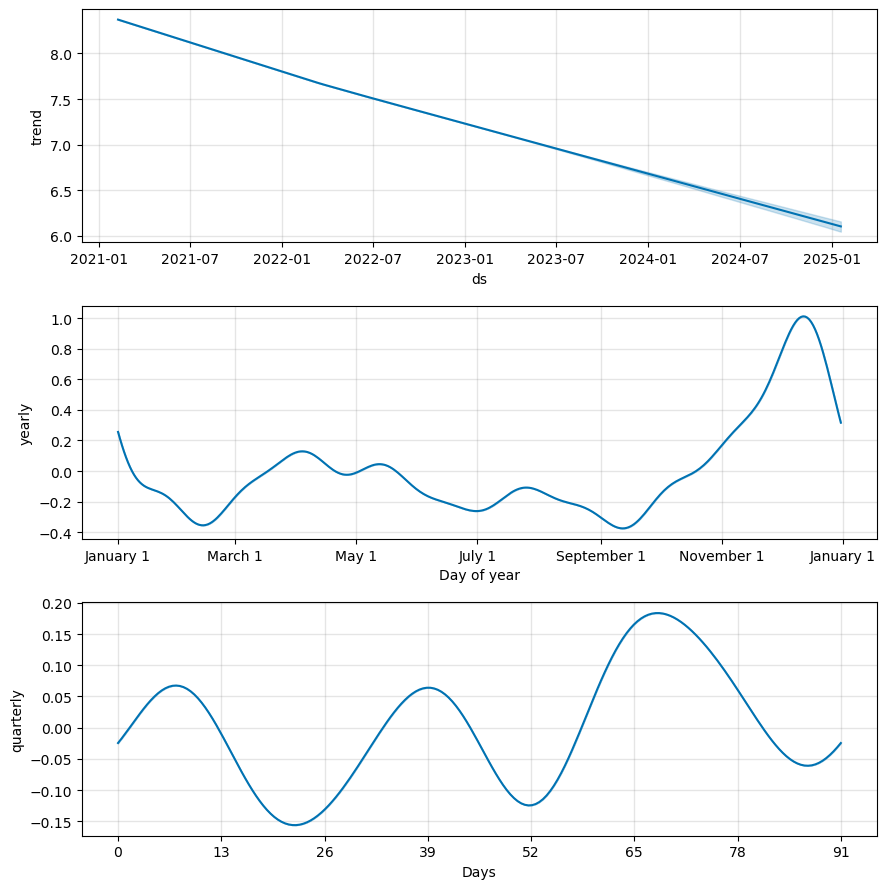

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Prepare data (log transform)
# -----------------------------

train_df = weekly_series[['ds', 'y']].copy()
train_df['y'] = np.log1p(train_df['y'])

# -----------------------------
# 2. Define final Prophet model
# -----------------------------

m = Prophet(
    growth='linear',
    seasonality_mode='additive',
    yearly_seasonality=True,
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=5,
    interval_width=0.95
)

# Add quarterly seasonality
m.add_seasonality(
    name='quarterly',
    period=365.25 / 4,
    fourier_order=5
)

# Fit model
m.fit(train_df)

# -----------------------------
# 3. Cross-validation evaluation
# -----------------------------

df_cv = cross_validation(
    m,
    initial='365 days',
    period='90 days',
    horizon='180 days'
)

df_p = performance_metrics(df_cv)

# Convert CV predictions back to count space
df_cv_counts = df_cv.copy()
df_cv_counts['y_count'] = np.expm1(df_cv_counts['y'])
df_cv_counts['yhat_count'] = np.expm1(df_cv_counts['yhat'])

mse_count = np.mean((df_cv_counts['y_count'] - df_cv_counts['yhat_count'])**2)
rmse_count = np.sqrt(mse_count)

print("Cross-Validated MSE (count space):", mse_count)
print("Cross-Validated RMSE (count space):", rmse_count)

# -----------------------------
# 4. Forecast 2024
# -----------------------------

future = m.make_future_dataframe(periods=104, freq='W')
forecast_log = m.predict(future)

# Convert forecast back to counts
forecast = forecast_log.copy()
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = np.expm1(forecast[col]).clip(lower=0)

# Extract 2024 predictions
pred_2024 = forecast.loc[
    (forecast['ds'] >= '2024-01-01') &
    (forecast['ds'] < '2025-01-01'),
    ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
].copy()

pred_2024.rename(columns={
    'yhat': 'pred_mean',
    'yhat_lower': 'ci95_lower',
    'yhat_upper': 'ci95_upper'
}, inplace=True)

print(pred_2024.to_string(index=False))

# -----------------------------
# 5. Plot results
# -----------------------------

fig1 = m.plot(forecast_log)
plt.title('Weekly Orders Forecast (Log Model)')
plt.xlabel('Date')
plt.ylabel('log1p(Orders)')
plt.show()

plt.figure()
plt.plot(pred_2024['ds'], pred_2024['pred_mean'])
plt.fill_between(
    pred_2024['ds'],
    pred_2024['ci95_lower'],
    pred_2024['ci95_upper'],
    alpha=0.2
)
plt.title('2024 Weekly Orders Forecast')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.show()

fig2 = m.plot_components(forecast_log)
plt.show()


In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def prophet_forecast_with_scale(
    series_df: pd.DataFrame,
    freq: str = "W",                      # "D", "W", "M", "Q"
    periods: int | None = None,           # if None, set sensible default by freq
    report_year: int = 2024,
    log_transform: bool = True,
    clip_nonnegative: bool = True,
    interval_width: float = 0.95,
    changepoint_prior_scale: float = 0.01,
    seasonality_prior_scale: float = 5.0,
    seasonality_mode: str = "additive",   # "additive" or "multiplicative"
    add_quarterly_seasonality: bool = True,
    quarterly_fourier_order: int = 5,
    cv_initial: str | None = None,
    cv_period: str | None = None,
    cv_horizon: str | None = None,
):
    """
    series_df must have columns: ['ds','y'] already aggregated at the desired grain OR raw.
    This function:
      1) optionally re-resamples to freq (if ds not already on that freq, it will aggregate)
      2) fits Prophet
      3) runs CV and prints MSE/RMSE in count space
      4) forecasts forward and prints report_year predictions with CI
      5) plots forecast + components + report_year chart
    """

    # -----------------------------
    # 0) Resample/aggregate to desired frequency
    # -----------------------------
    df = series_df[['ds', 'y']].copy()
    df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

    # If the input is event-level counts already aggregated, resampling with sum is safe.
    # If your df has one row per event, set y=1 before calling this function.
    df = (
        df.set_index('ds')
          .resample(freq)['y']
          .sum()
          .reset_index()
    )

    # Drop last row (often incomplete period)
    if len(df) > 1:
        df = df.iloc[:-1].copy()

    # -----------------------------
    # 1) Prepare training data
    # -----------------------------
    train_df = df.copy()
    if log_transform:
        train_df['y'] = np.log1p(train_df['y'])

    # -----------------------------
    # 2) Sensible defaults by frequency
    # -----------------------------
    if periods is None:
        periods = {"D": 730, "W": 104, "M": 24, "Q": 8}.get(freq, 104)

    if cv_initial is None or cv_period is None or cv_horizon is None:
        defaults = {
            "D": ("365 days", "90 days", "180 days"),
            "W": ("365 days", "90 days", "180 days"),
            "M": ("365 days", "30 days", "90 days"),
            "Q": ("730 days", "90 days", "180 days"),
        }
        d_init, d_period, d_horizon = defaults.get(freq, ("365 days", "90 days", "180 days"))
        cv_initial = cv_initial or d_init
        cv_period = cv_period or d_period
        cv_horizon = cv_horizon or d_horizon

    # -----------------------------
    # 3) Define and fit model
    # -----------------------------
    m = Prophet(
        growth='linear',
        seasonality_mode=seasonality_mode,
        yearly_seasonality=True,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        interval_width=interval_width
    )

    if add_quarterly_seasonality:
        m.add_seasonality(
            name='quarterly',
            period=365.25 / 4,
            fourier_order=quarterly_fourier_order
        )

    m.fit(train_df)

    # -----------------------------
    # 4) Cross-validation evaluation
    # -----------------------------
    df_cv = cross_validation(
        m,
        initial=cv_initial,
        period=cv_period,
        horizon=cv_horizon
    )
    df_p = performance_metrics(df_cv)

    # Convert CV back to count space if log-transformed
    if log_transform:
        df_cv_counts = df_cv.copy()
        df_cv_counts['y_count'] = np.expm1(df_cv_counts['y'])
        df_cv_counts['yhat_count'] = np.expm1(df_cv_counts['yhat'])
        mse_count = np.mean((df_cv_counts['y_count'] - df_cv_counts['yhat_count'])**2)
        rmse_count = np.sqrt(mse_count)
    else:
        mse_count = df_p['mse'].mean()
        rmse_count = df_p['rmse'].mean()

    print(f"Frequency: {freq}")
    print("Cross-Validated MSE (count space):", mse_count)
    print("Cross-Validated RMSE (count space):", rmse_count)

    # -----------------------------
    # 5) Forecast forward
    # -----------------------------
    future = m.make_future_dataframe(periods=periods, freq=freq)
    forecast_pred = m.predict(future)

    # Convert forecast back to count space if log-transformed
    forecast = forecast_pred.copy()
    if log_transform:
        for col in ['yhat', 'yhat_lower', 'yhat_upper']:
            forecast[col] = np.expm1(forecast[col])

    if clip_nonnegative:
        for col in ['yhat', 'yhat_lower', 'yhat_upper']:
            forecast[col] = forecast[col].clip(lower=0)

    # Extract report_year predictions
    start = pd.Timestamp(f'{report_year}-01-01')
    end = pd.Timestamp(f'{report_year+1}-01-01')
    pred_year = forecast.loc[
        (forecast['ds'] >= start) & (forecast['ds'] < end),
        ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
    ].copy()

    pred_year.rename(columns={
        'yhat': 'pred_mean',
        'yhat_lower': 'ci95_lower',
        'yhat_upper': 'ci95_upper'
    }, inplace=True)

    print(f"\n{report_year} Predictions with {int(interval_width*100)}% CI ({freq}):")
    print(pred_year.to_string(index=False))

    # -----------------------------
    # 6) Plots
    # -----------------------------
    # Prophet's built-in plot (in model space if log_transform else count space)
    fig1 = m.plot(forecast_pred)
    plt.title(f'Orders Forecast (freq={freq}, model_space={"log" if log_transform else "count"})')
    plt.xlabel('Date')
    plt.ylabel('log1p(Orders)' if log_transform else 'Orders')
    plt.show()

    # Clean plot in count space for report_year
    plt.figure()
    plt.plot(pred_year['ds'], pred_year['pred_mean'])
    plt.fill_between(pred_year['ds'], pred_year['ci95_lower'], pred_year['ci95_upper'], alpha=0.2)
    plt.title(f'{report_year} Orders Forecast (freq={freq}, count space)')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.show()

    # Components plot (still in model space)
    fig2 = m.plot_components(forecast_pred)
    plt.show()

    return {
        "model": m,
        "train_series": df,           # resampled series in count space
        "forecast": forecast,         # forecast in count space
        "pred_year": pred_year,       # year slice in count space
        "mse": float(mse_count),
        "rmse": float(rmse_count),
        "cv_metrics": df_p
    }


/var/folders/3g/fzqltvr90_11xv3v1sxb4f2m0000gn/T/ipykernel_10648/1463039648.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(freq)['y']
11:52:12 - cmdstanpy - INFO - Chain [1] start processing
11:52:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/8 [00:00<?, ?it/s]11:52:13 - cmdstanpy - INFO - Chain [1] start processing
11:52:13 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 1/8 [00:00<00:02,  2.78it/s]11:52:13 - cmdstanpy - INFO - Chain [1] start processing
11:52:14 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 2/8 [00:00<00:01,  3.10it/s]11:52:14 - cmdstanpy - INFO - Chain [1] start processing
11:52:14 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 3/8 [00:00<00:01,  3.29it/s]11:52:14 - cmdstanpy - INFO - Chain [1] start processing
11:52:23 -

Frequency: M
Cross-Validated MSE (count space): 2663880028.419693
Cross-Validated RMSE (count space): 51612.789388093464

2024 Predictions with 95% CI (M):
        ds  pred_mean  ci95_lower  ci95_upper
2024-01-31 248.878686   246.55473  251.161377
2024-02-29   0.000000     0.00000    0.000000
2024-03-31   0.000000     0.00000    0.000000
2024-04-30   0.000000     0.00000    0.000000
2024-05-31   0.000000     0.00000    0.000000
2024-06-30   0.000000     0.00000    0.000000
2024-07-31   0.000000     0.00000    0.000000
2024-08-31   0.000000     0.00000    0.000000
2024-09-30   0.000000     0.00000    0.000000
2024-10-31   0.000000     0.00000    0.000000
2024-11-30   0.000000     0.00000    0.000000
2024-12-31   0.000000     0.00000    0.000000


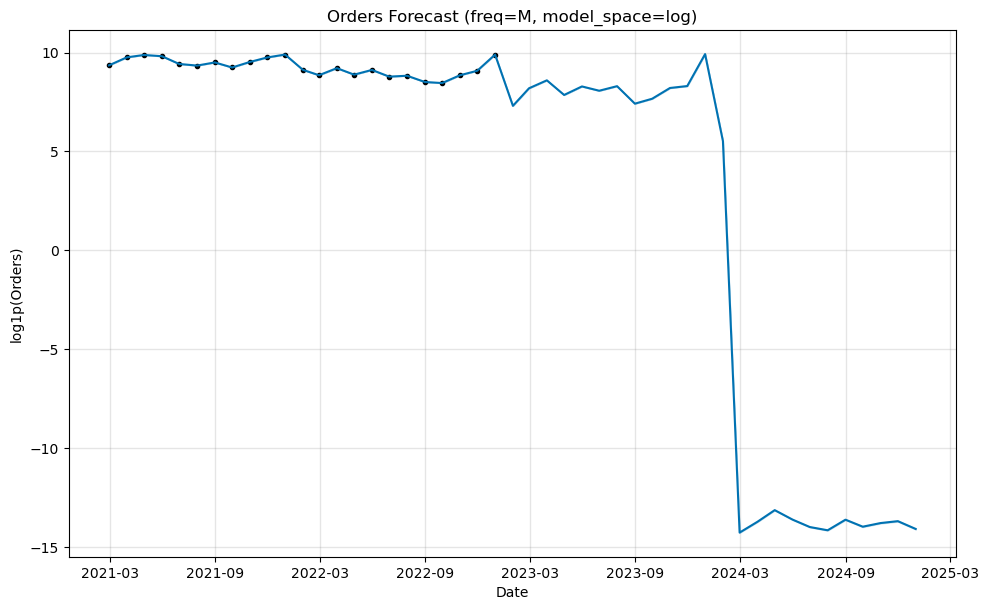

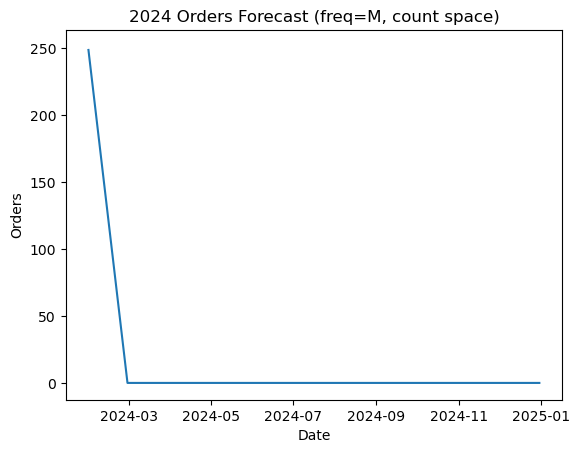

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

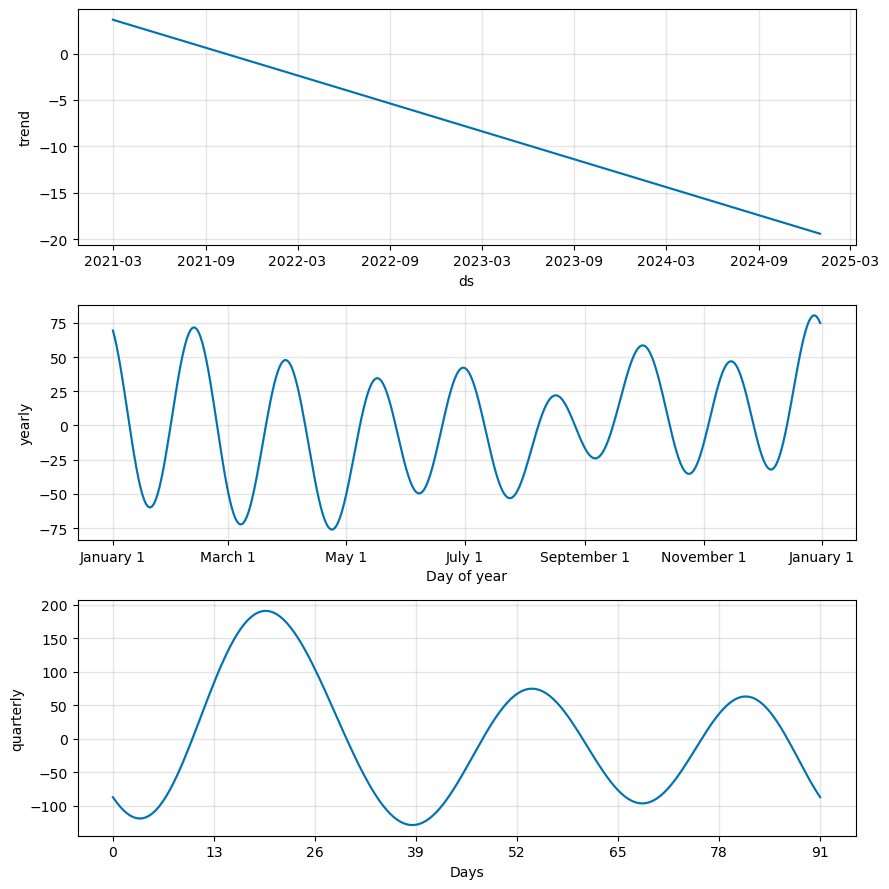

In [ ]:
out_monthly = prophet_forecast_with_scale(weekly_series, freq="M", cv_horizon="90 days")

11:52:28 - cmdstanpy - INFO - Chain [1] start processing
11:52:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/2 [00:00<?, ?it/s]11:52:28 - cmdstanpy - INFO - Chain [1] start processing
11:52:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  4.60it/s]11:52:28 - cmdstanpy - INFO - Chain [1] start processing
11:52:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  4.47it/s]
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:73:

Frequency: W
Cross-Validated MSE (count space): 579389.133236536
Cross-Validated RMSE (count space): 761.1761512531353

2024 Predictions with 95% CI (W):
        ds   pred_mean  ci95_lower  ci95_upper
2024-01-07  857.960424  586.857350 1231.692298
2024-01-14  690.932214  482.828865  957.690752
2024-01-21  548.106616  380.916792  775.225181
2024-01-28  522.775402  368.970359  732.562362
2024-02-04  548.793454  388.476669  803.332572
2024-02-11  545.516048  374.865257  776.901509
2024-02-18  486.942612  331.044814  701.704325
2024-02-25  502.492294  348.967426  719.348744
2024-03-03  663.777893  461.453731  931.901279
2024-03-10  786.248219  556.847482 1122.774644
2024-03-17  772.426541  528.618993 1082.363695
2024-03-24  720.546220  517.048439 1033.399956
2024-03-31  722.299604  517.111531 1028.440897
2024-04-07  795.453764  550.783844 1131.176846
2024-04-14  715.631583  504.882050 1019.839366
2024-04-21  563.891523  403.139843  792.742525
2024-04-28  554.286287  380.042850  769.912577


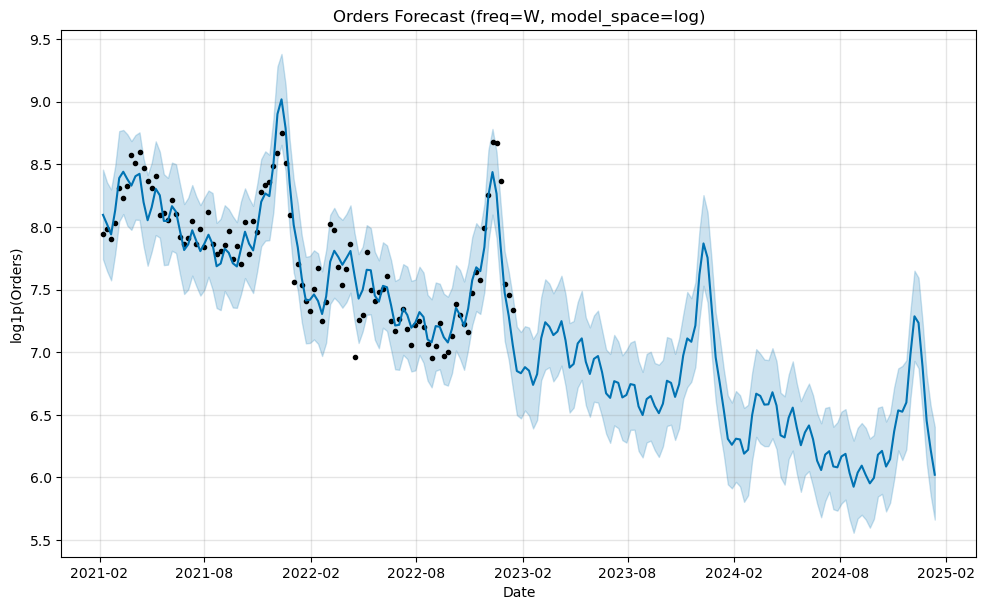

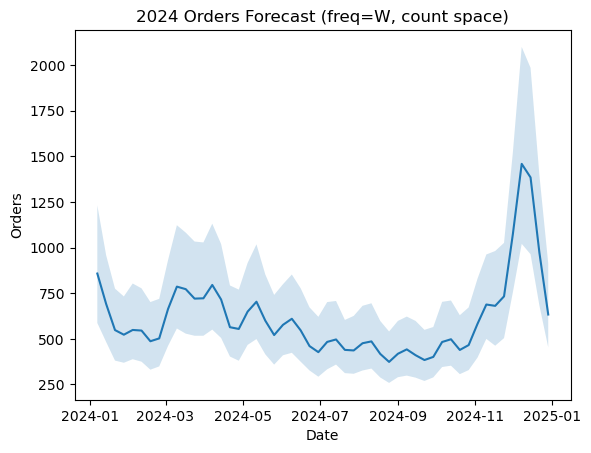

/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/miniconda3/envs/env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To 

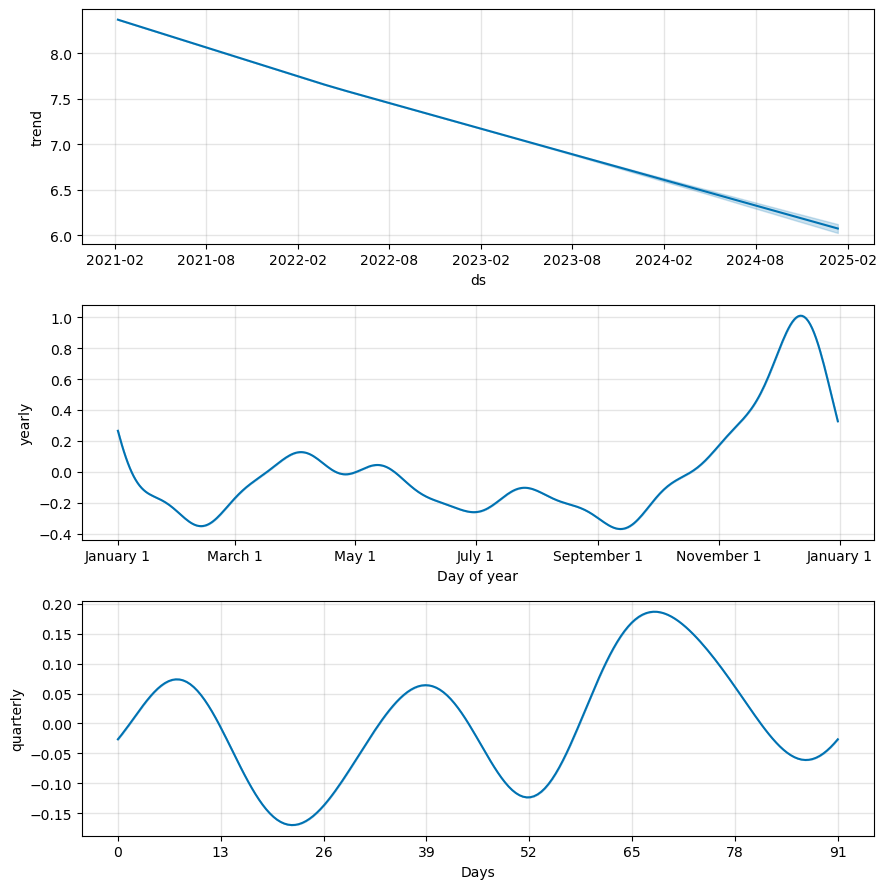

In [ ]:
out_weekly = prophet_forecast_with_scale(weekly_series, freq="W")
